In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, ActNorm2D, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [4]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [5]:
import mylibrary.datasets as datasets
# import mylibrary.nnlib as tnn

In [6]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [7]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [8]:
input_size = 784
output_size = 10

In [9]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data.reshape(-1, 1, 28, 28)
        self.label = label
        
#         self.label = mask.type(torch.float32).reshape(-1,1)
        self._shuffle_data_()
        
    def __len__(self):
        return len(self.data)
    
    def _shuffle_data_(self):
        randidx = random.sample(range(len(self.data)), k=len(self.data))
        self.data = self.data[randidx]
        self.label = self.label[randidx]
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [10]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [11]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [12]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
        self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.randn(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [13]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
#             init_val[ns, 0] = 2. ### initialize same class in all clusters

        self.cls_weight = nn.Parameter(init_val)
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data = torch.abs(self.cls_weight.data)/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
    
    def set_centroid_to_data_randomly(self, data_loader, model):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        xx = data_loader.dataset.data[indices].to(self.centers.device)
        yy = data_loader.dataset.label[indices].to(self.centers.device)
        yout = model(xx)
        self.centers.data = yout
        
        init_val = torch.ones(self.num_sets, self.output_dim)/self.output_dim
        for ns in range(len(indices)):
            init_val[ns, yy[ns]] = 1.
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [14]:
# actf = nn.SELU
# flows = [
#     nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
#     nn.BatchNorm2d(32),
#     actf(),
#     nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 1, kernel_size=5, padding=2),
#     actf(),
#     irf.Flatten(img_size=(1, 28, 28)),
#     nn.BatchNorm1d(1*28*28),
#         ]

# model = nn.Sequential(*flows)

In [15]:
# model(torch.randn(3, 1, 28, 28)).shape

In [16]:
actf = irf.Swish
flows = [
    ActNorm2D(1),
    irf.ConvResidualFlow_v2([1, 28, 28], [16], activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(4),
    irf.ConvResidualFlow_v2([4, 14, 14], [64], activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(16),
    irf.ConvResidualFlow_v2([16, 7, 7], [64, 64], activation=actf),
    ActNorm2D(16),
    irf.Flatten(img_size=(16, 7, 7)),
    ActNorm(16*7*7),
        ]

backbone = SequentialFlow(flows)

In [17]:
# actf = irf.Swish
# flows = [
#     nn.BatchNorm2d(1),
#     irf.ConvResidualFlow(1, [16], activation=actf),
#     irf.InvertiblePooling(2),
#     nn.BatchNorm2d(4),
#     irf.ConvResidualFlow(4, [64], activation=actf),
#     irf.InvertiblePooling(2),
#     nn.BatchNorm2d(16),
#     irf.ConvResidualFlow(16, [64, 64], activation=actf),
#     irf.Flatten(img_size=(16, 7, 7)),
#     nn.BatchNorm1d(16*7*7),
#         ]

# backbone = nn.Sequential(*flows)

In [18]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [19]:
def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")

In [20]:
# remove_spectral_norm(backbone)

In [21]:
# backbone = nn.Sequential(nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                       nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                      )

In [22]:
backbone.to(device)

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm2D()
    (1): ConvResidualFlow_v2(
      (resblock): ModuleList(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): InvertiblePooling()
    (3): ActNorm2D()
    (4): ConvResidualFlow_v2(
      (resblock): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): InvertiblePooling()
    (6): ActNorm2D()
    (7): ConvResidualFlow_v2(
      (resblock): ModuleList(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Swish()
        (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [23]:
for xx, yy in test_loader:
    break
backbone(xx.to(device)).shape

torch.Size([50, 784])

In [24]:
for p in backbone.parameters():
    print(p.device)
    break

cuda:0


In [25]:
# actf = irf.Swish
# _flows = [
#     ActNorm(2),
#     irf.ResidualFlow(2, [20, 20], activation=actf),
#     ActNorm(2),
#         ]
# _clasf = SequentialFlow(_flows)
# _clasf = nn.Sequential(nn.Linear(784, 2), _clasf)

classifier = nn.Sequential(
                nn.Linear(784, 2),
#                 _clasf,
                ConnectedClassifier_SoftKMeans(2, 20, 10)
#                 ConnectedClassifier_Linear(2, 100, 10)
            )

# classifier = nn.Sequential(
#                 nn.Linear(784, 2),
#                 nn.Sequential(
#                     nn.Linear(2, 20), nn.SiLU(), nn.Linear(20, 10)
#                 ),
#             )

In [26]:
# classifier = ConnectedClassifier_SoftKMeans(784, 100, 10)
# classifier = ConnectedClassifier_Softmax(784, 100, 10)
classifier = classifier.to(device)

## Model Train

In [27]:
model = nn.Sequential(backbone, classifier)#.to(device)

In [28]:
# classifier[1].set_centroid_to_data_randomly(train_loader, nn.Sequential(model, classifier[0]))

In [29]:
learning_rate = 0.001
EPOCHS = 50

In [30]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


print("number of params: ", sum(p.numel() for p in backbone.parameters()))

number of params:  62067


In [31]:
# for p in backbone.parameters():
#     print(torch.isnan(p).type(torch.float32).sum())

In [32]:
# backbone(torch.randn(10, 784).to(device)).shape

In [33]:
losses = []
train_accs = []
test_accs = []
best_model = model.state_dict()
model_name = "invmlp_fmnist_2D_v1"

In [34]:
index = 0
best_acc = -1
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    model.train()
    for xx, yy in tqdm(train_loader):
        xx, yy = xx.to(device), yy.to(device)
#     for xx, yy in tqdm(test_loader):

        yout = backbone(xx)
#         print(yout)
        yout = classifier(yout)    
#         print(yout)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(float(loss))

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)
#         break

    scheduler.step()

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    model.eval()
    for xx, yy in tqdm(test_loader):
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = classifier(backbone(xx))    
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    if test_accs[-1] > best_acc:
        print('Saving..')
        state = {'model': model.state_dict(),'acc': test_accs[-1],'epoch': epoch,}
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = test_accs[-1]
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.15it/s]


Epoch: 0:0,  Loss:1.9791574478149414


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 240.31it/s]


Saving..
Train Acc:51.40%, Test Acc:57.08%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.30it/s]


Epoch: 1:0,  Loss:1.8952267169952393


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 246.10it/s]


Saving..
Train Acc:62.09%, Test Acc:70.39%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 81.81it/s]


Epoch: 2:0,  Loss:1.7733314037322998


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 243.37it/s]


Saving..
Train Acc:74.93%, Test Acc:75.55%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.33it/s]


Epoch: 3:0,  Loss:1.699472188949585


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 244.36it/s]


Saving..
Train Acc:78.17%, Test Acc:78.18%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.42it/s]


Epoch: 4:0,  Loss:1.709290623664856


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 244.70it/s]


Saving..
Train Acc:79.19%, Test Acc:78.28%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.96it/s]


Epoch: 5:0,  Loss:1.6802884340286255


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 250.92it/s]


Saving..
Train Acc:79.68%, Test Acc:78.62%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.34it/s]


Epoch: 6:0,  Loss:1.6553962230682373


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 248.31it/s]


Train Acc:80.07%, Test Acc:77.99%



100%|█████████████████████████████████████████████████| 1200/1200 [00:15<00:00, 79.25it/s]


Epoch: 7:0,  Loss:1.7055528163909912


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 245.66it/s]


Train Acc:80.28%, Test Acc:78.32%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.37it/s]


Epoch: 8:0,  Loss:1.686479926109314


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 250.15it/s]


Saving..
Train Acc:80.71%, Test Acc:79.53%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.87it/s]


Epoch: 9:0,  Loss:1.7054654359817505


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 240.53it/s]


Saving..
Train Acc:81.11%, Test Acc:79.80%



100%|█████████████████████████████████████████████████| 1200/1200 [00:15<00:00, 79.56it/s]


Epoch: 10:0,  Loss:1.675889253616333


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 245.69it/s]


Train Acc:81.32%, Test Acc:79.73%



100%|█████████████████████████████████████████████████| 1200/1200 [00:15<00:00, 79.98it/s]


Epoch: 11:0,  Loss:1.6343727111816406


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 246.21it/s]


Saving..
Train Acc:81.62%, Test Acc:79.93%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 81.37it/s]


Epoch: 12:0,  Loss:1.722795009613037


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 244.41it/s]


Train Acc:82.05%, Test Acc:79.82%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.19it/s]


Epoch: 13:0,  Loss:1.6926970481872559


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 244.62it/s]


Saving..
Train Acc:82.55%, Test Acc:80.38%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.24it/s]


Epoch: 14:0,  Loss:1.6942428350448608


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 241.86it/s]


Saving..
Train Acc:83.01%, Test Acc:81.19%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.56it/s]


Epoch: 15:0,  Loss:1.6821895837783813


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 248.21it/s]


Train Acc:83.45%, Test Acc:80.88%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.66it/s]


Epoch: 16:0,  Loss:1.662656307220459


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 244.78it/s]


Saving..
Train Acc:83.91%, Test Acc:82.48%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 81.41it/s]


Epoch: 17:0,  Loss:1.6173878908157349


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 235.87it/s]


Saving..
Train Acc:84.92%, Test Acc:82.64%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.89it/s]


Epoch: 18:0,  Loss:1.561811923980713


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 242.08it/s]


Saving..
Train Acc:85.85%, Test Acc:84.37%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.50it/s]


Epoch: 19:0,  Loss:1.6666183471679688


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 249.08it/s]


Train Acc:86.30%, Test Acc:84.03%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.50it/s]


Epoch: 20:0,  Loss:1.7066692113876343


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 242.43it/s]


Train Acc:86.73%, Test Acc:83.88%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 80.23it/s]


Epoch: 21:0,  Loss:1.5987056493759155


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 248.61it/s]


Saving..
Train Acc:87.12%, Test Acc:84.55%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.43it/s]


Epoch: 22:0,  Loss:1.599776029586792


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 242.20it/s]


Train Acc:87.63%, Test Acc:84.19%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.32it/s]


Epoch: 23:0,  Loss:1.630181074142456


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 246.20it/s]


Train Acc:87.85%, Test Acc:84.49%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.17it/s]


Epoch: 24:0,  Loss:1.6598114967346191


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 241.69it/s]


Train Acc:88.20%, Test Acc:84.29%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.25it/s]


Epoch: 25:0,  Loss:1.5781683921813965


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 248.89it/s]


Saving..
Train Acc:88.59%, Test Acc:85.36%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.31it/s]


Epoch: 26:0,  Loss:1.6207939386367798


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 247.19it/s]


Saving..
Train Acc:88.81%, Test Acc:85.86%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.58it/s]


Epoch: 27:0,  Loss:1.5412603616714478


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 239.22it/s]


Train Acc:89.05%, Test Acc:85.38%



100%|█████████████████████████████████████████████████| 1200/1200 [00:14<00:00, 82.38it/s]


Epoch: 28:0,  Loss:1.5937597751617432


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 242.90it/s]


Train Acc:89.39%, Test Acc:85.55%



 27%|█████████████▋                                    | 329/1200 [00:04<00:10, 80.32it/s]


KeyboardInterrupt: 

In [ ]:
asdasd

In [35]:
classifier[1].inv_temp#, classifier[1].power 

Parameter containing:
tensor([12.8653], device='cuda:0', requires_grad=True)

In [36]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(85.86, 26)

In [37]:
# model = nn.Sequential(model, backbone)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Hard test accuracy with count per classifier

In [38]:
model.eval()

Sequential(
  (0): SequentialFlow(
    (flows): ModuleList(
      (0): ActNorm2D()
      (1): ConvResidualFlow_v2(
        (resblock): ModuleList(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Swish()
          (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (2): InvertiblePooling()
      (3): ActNorm2D()
      (4): ConvResidualFlow_v2(
        (resblock): ModuleList(
          (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Swish()
          (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (5): InvertiblePooling()
      (6): ActNorm2D()
      (7): ConvResidualFlow_v2(
        (resblock): ModuleList(
          (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Swish()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Swish()
       

In [39]:
backbone, classifier = model[0], model[1]

In [40]:
classifier

Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): ConnectedClassifier_SoftKMeans()
)

In [41]:
test_count = 0
test_acc = 0
# set_count = torch.zeros(classifier.num_sets).to(device)
set_count = torch.zeros(classifier[1].num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(backbone(xx), hard=True)
        yout = classifier[1](classifier[0](backbone(xx)), hard=True)
    
#         set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_indx, count = torch.unique(torch.argmax(classifier[1].cls_confidence, dim=1), return_counts=True)
    
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 244.85it/s]

Hard Test Acc:85.84%
[118, 922, 83, 27, 1180, 1012, 655, 91, 5, 791, 168, 46, 946, 953, 996, 980, 288, 3, 17, 719]


In [42]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(20, device='cuda:0')

In [43]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(backbone(xx), hard=True)
        embs = classifier[0](backbone(xx))
        embeddings.append(embs.cpu())
        
#         yout = classifier[1](embs, hard=True)
        yout = classifier[1](embs)
        labels.append(torch.argmax(yout, dim=1).cpu())
        
        
    

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)
# maxims = torch.cat(maxims, dim=0)

100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 222.71it/s]


In [44]:
## Plot scatter plot of images
# https://nextjournal.com/ml4a/image-t-sne

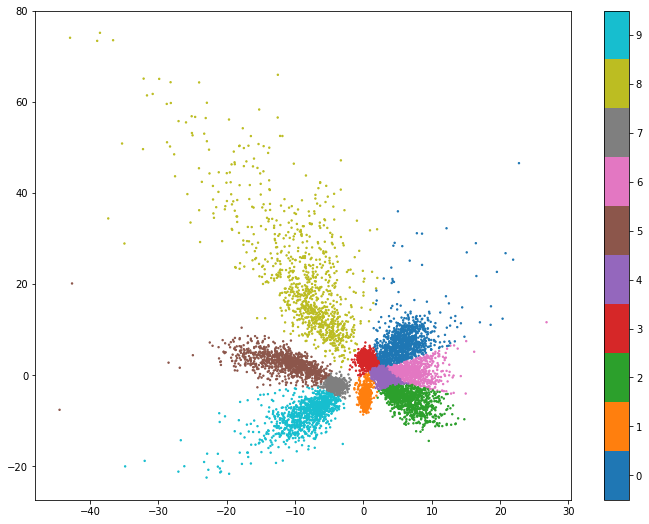

In [45]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/01_prediction_fmnist.pdf')

In [46]:
# fig, ax = plt.subplots(1, figsize=(12, 9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

# plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(list(range(10)))

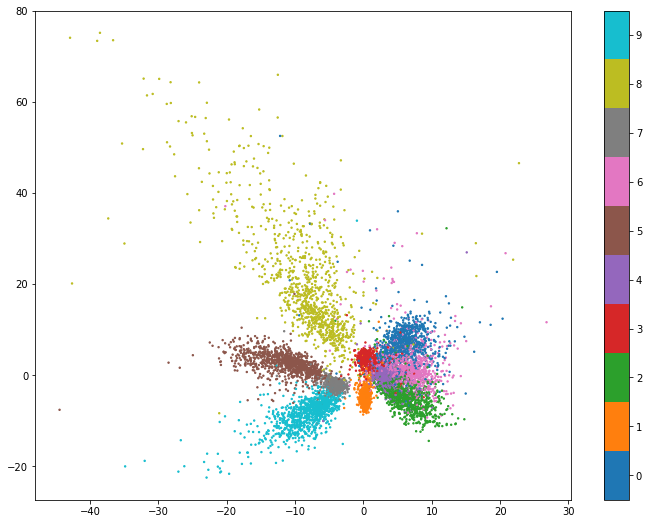

In [47]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/02_ground_truth_fmnist_mlp.pdf')

In [48]:
torch.count_nonzero(labels==ilabels)

tensor(8586)

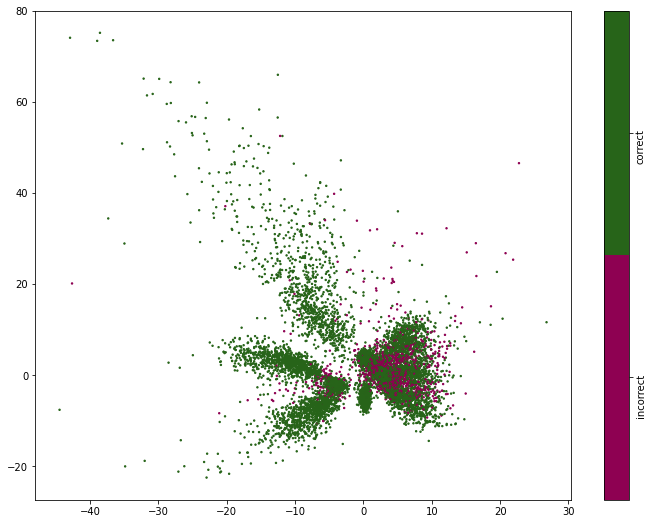

In [49]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2, cmap='PiYG')
cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['incorrect', 'correct', ])
cbar.ax.tick_params(rotation=90)

# mask = torch.nonzero(labels==ilabels)
# plt.scatter(embeddings[mask,0], embeddings[mask, 1], s=2, c='g', label='correct')
# mask = torch.nonzero(labels!=ilabels)
# plt.scatter(embeddings[mask,0], embeddings[mask, 1], s=2, c='orangered', label='incorrect')
# plt.legend()
# plt.savefig('./output/03_errors_fmnist.pdf')

In [50]:
## plot on a 2D map, the decision boundary
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

/home/tsuman/All_Files/Program_Files/miniconda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [51]:
xyg.shape

torch.Size([1000000, 2])

In [59]:
BS = 1000
output, maxims = [], []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier[1](xx)
#         yout = classifier[1](xx, hard=True)
        output.append(torch.argmax(yout, dim=1).cpu())
        
        dists = torch.cdist(xx, classifier[1].centers)
        dists = dists/np.sqrt(classifier[1].input_dim) ### correction to make diagonal of unit square 1 in nD space

        mask = torch.argmin(dists, dim=1) ## reusing embs.. it is one hot to select distance
        mask = dists[torch.arange(len(mask), dtype=torch.long), mask]
        maxims.append((mask*classifier[1].inv_temp).cpu())
        


output = torch.cat(output, dim=0)
maxims = torch.cat(maxims, dim=0)

In [60]:
# maxims.shape

In [61]:
# xyg[:,0].reshape(xg.shape).shape,xyg[:,1].reshape(yg.shape).shape, maxims.reshape(xg.shape).shape

In [62]:
# ## plot 3D for the distance
# %matplotlib inline
# fig = plt.figure(figsize=(11,9))

# ax = fig.gca(projection='3d')
# ax.view_init(elev=10., azim=2)
# ax.plot_surface(xyg[:,0].numpy().reshape(xg.shape),
#                 xyg[:,1].numpy().reshape(yg.shape),
#                 -maxims.cpu().numpy().reshape(xg.shape))
    
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('D')
# plt.show()

In [63]:
# plt.figure(figsize=(12,9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
# cf = plt.contourf(xyg[:,0].reshape(xg.shape),
#                  xyg[:,1].reshape(yg.shape),
#                  output.reshape(xg.shape), levels=9,
#                  alpha=0.5, cmap="tab10", antialiased=True)

In [64]:
### plot centroids as well

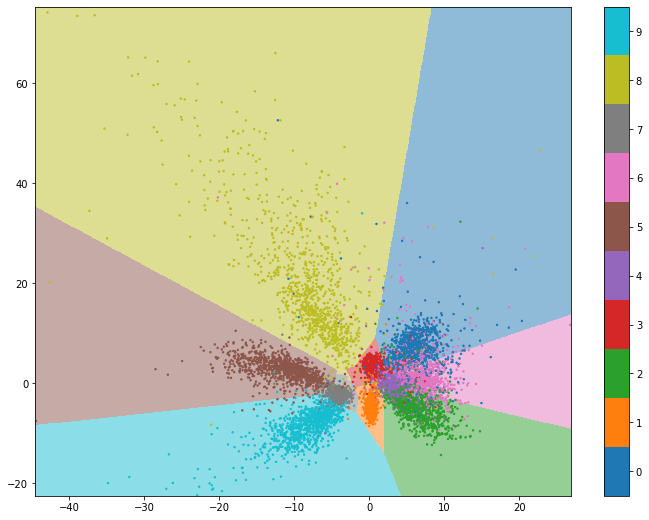

In [65]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

# plt.savefig('./output/04_DecisionBoundary_Class_fmnist.pdf')

In [66]:
## display different class boundary

BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier[1](xx, hard=True)
        output2.append(torch.argmax(classifier[1].cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

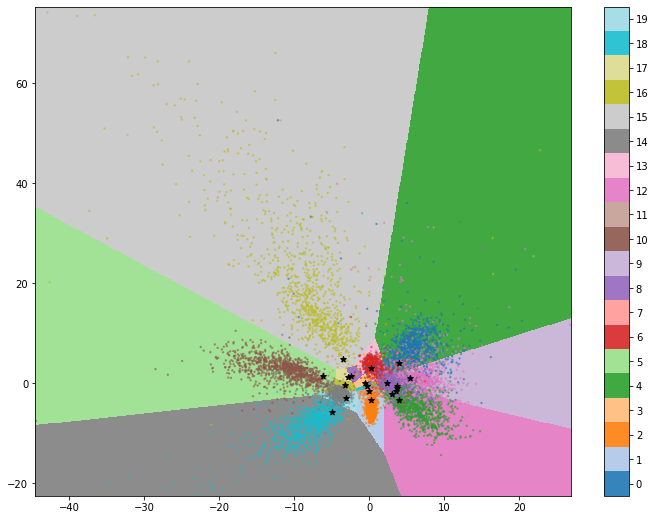

In [67]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10', alpha=0.5)

plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.9, cmap='tab20',
           aspect='auto', origin='lower')

cbar = plt.colorbar(ticks=range(20), #label='classes', 
                    boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(list(range(20)))

### plot centroids as well
plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')

# plt.savefig('./output/05_DecisionBoundary_Sets_fmnist.pdf')

### Hard train accuracy with count per classifier

In [ ]:
test_count = 0
test_acc = 0
# set_count = torch.zeros(classifier.num_sets).to(device)
set_count = torch.zeros(classifier[1].num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        yout = classifier[1](classifier[0](model(xx)), hard=True)
        
#         set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_indx, count = torch.unique(torch.argmax(classifier[1].cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

In [ ]:
#### classifier with class representation
torch.argmax(classifier[1].cls_weight, dim=1)

In [ ]:
# The class labels are same as that of initialized
# tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
#         4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
#         8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
#         2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
#         6, 7, 8, 9], device='cuda:0')

In [ ]:
classifier[1].cls_weight

In [ ]:
# torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

In [ ]:
classifier[1].inv_temp

In [ ]:
### example output per classifier
yout[5]

In [ ]:
asdfsdf ## to break the code

## UMAP - Viz

In [ ]:
import umap

In [ ]:
imgs, labels = [], []
for xx, yy in tqdm(train_loader):
    imgs.append(xx)
    labels.append(yy)

imgs = torch.cat(imgs, dim=0)
labels = torch.cat(labels, dim=0)

In [ ]:
embed = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, spread=1, metric="euclidean")
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [ ]:
embedding = embed.fit_transform(imgs.numpy().reshape(-1, 28*28))

In [ ]:
imgs_, labels_ = [], []
for xx, yy in tqdm(test_loader):
    imgs_.append(xx)
    labels_.append(yy)

imgs_ = torch.cat(imgs_, dim=0)
labels_ = torch.cat(labels_, dim=0)

In [ ]:
embedding_ = embed.transform(imgs_.numpy().reshape(-1, 28*28))

In [ ]:
plt.figure(figsize=(12,9))

plt.scatter(embedding_[:,0], embedding_[:, 1], c=labels_, s=2, cmap="tab10")

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

# plt.xlim(xg.min(), xg.max())
# plt.ylim(yg.min(), yg.max()) 
plt.savefig('./output/UMAP_fmnist.pdf')

In [ ]:
plt.figure(figsize=(12,9))

plt.scatter(embedding[:,0], embedding[:, 1], c=labels, s=2, cmap="tab10")

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

# plt.xlim(xg.min(), xg.max())
# plt.ylim(yg.min(), yg.max()) 
plt.savefig('./output/UMAP_fmnist_train.pdf')

## Visualize embeddings for MNIST dataset

In [ ]:
def get_mnist_data_loaders():
    mnist = datasets.MNIST()
    # mnist.download_mnist()
    # mnist.save_mnist()
    train_data, train_label_, test_data, test_label_ = mnist.load()

    train_data = train_data / 255.
    test_data = test_data / 255.

    # train_label = tnn.Logits.index_to_logit(train_label_)
    train_size = len(train_label_)

    ## converting data to pytorch format
    train_data = torch.Tensor(train_data)
    test_data = torch.Tensor(test_data)
    train_label = torch.LongTensor(train_label_)
    test_label = torch.LongTensor(test_label_)

    input_size = 784
    output_size = 10

    class MNIST_Dataset2(data.Dataset):

        def __init__(self, data, label):
            self.data = data.reshape(-1, 1, 28, 28)
            self.label = label

    #         self.label = mask.type(torch.float32).reshape(-1,1)
            self._shuffle_data_()

        def __len__(self):
            return len(self.data)

        def _shuffle_data_(self):
            randidx = random.sample(range(len(self.data)), k=len(self.data))
            self.data = self.data[randidx]
            self.label = self.label[randidx]

        def __getitem__(self, idx):
            img, lbl = self.data[idx], self.label[idx]
            return img, lbl

    train_dataset = MNIST_Dataset2(train_data, train_label)
    test_dataset = MNIST_Dataset2(test_data, test_label)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
#### Find embedding for mnist dataset

_, test_loader2 = get_mnist_data_loaders()

embeddings_, labels_, ilabels_ = [], [], []
model.eval()
for xx, yy in tqdm(test_loader2):
    ilabels_.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        embs = classifier[0](model(xx))
        embeddings_.append(embs.cpu())
        
        yout = classifier[1](embs, hard=True)
        labels_.append(torch.argmax(yout, dim=1).cpu())
        
embeddings_ = torch.cat(embeddings_, dim=0)
labels_ = torch.cat(labels_, dim=0)
ilabels_ = torch.cat(ilabels_, dim=0)

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab20',
           aspect='auto', origin='lower')
### plot centroids as well
plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')

plt.scatter(embeddings_[:,0], embeddings_[:, 1], c='k', s=2,  cmap='tab10')
# plt.savefig('./output/06_mnist_on_fmnist_plot.pdf')

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")

### Benchmark - Robustness

In [ ]:
import foolbox as fb
import foolbox.attacks as fa

In [ ]:
epsilons = [0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
# epsilons = [0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0,]

#### Benchmark on full dataset

In [ ]:
attacks = [
    fa.FGSM(),
    fa.LinfPGD(),
    fa.LinfBasicIterativeAttack(),
#     fa.LinfAdditiveUniformNoiseAttack(),
#     fa.LinfDeepFoolAttack(),
]
atk_names = [
    "FGSM", 
    "LinfPGD", 
    "LinfBasicIterativeAttack", 
#     "LinfAdditiveUniformNoiseAttack", 
#     "LinfDeepFoolAttack",
]

In [ ]:
def get_attack_success(model, attack, dataloader):
    fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
    success_per_eps = []

    for eps in epsilons:
        count = 0
        total = 0
        print(f"Running one epoch attack for eps: {eps}")
        for i, (images, labels) in enumerate(tqdm(dataloader)):
            images, labels = images.to(device), labels.to(device)
            _, _, success = attack(fmodel, images, labels, epsilons=[eps])
            count += int(torch.count_nonzero(success))
            total += torch.numel(success)
#             break
        success_per_eps.append(count/total)
    return success_per_eps

In [ ]:
# get_attack_success(model, attacks[0], test_loader)

### Compute the robustness

In [ ]:
# outputs = {}

# model_ = nn.Sequential(model, classifier)

# model_.eval()
# ### load model and compute attack_success
# for j in range(len(attacks)):
#     attack = attacks[j]
#     atname = atk_names[j]

#     print(f"Attacking on model using {atname}")
#     succ_eps = get_attack_success(model_, attack, test_loader)
#     outputs[atname] = succ_eps
#     print(f"Success rate is : {succ_eps}")

In [ ]:
torch.cuda.current_device()

In [ ]:
# torch.cuda.set_device(1)

### View the embedding space

In [ ]:
model_ = nn.Sequential(model, classifier)
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)
fmodel.device = device

attack = attacks[0]
eps = epsilons[0]
print(f"Running one epoch attack for eps: {eps}")

true_emb, attk_emb = [], []
true_lbl, attk_lbl = [], []

count = 0
total = 0

for i, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.to(device), labels.to(device)
    _, adv, success = attack(fmodel, images, labels, epsilons=[eps])
    count += int(torch.count_nonzero(success))
    total += torch.numel(success)
    break

In [ ]:
adv[0].shape

In [ ]:
plt.imshow(adv[0][0,0].cpu())

In [ ]:
plt.imshow(images[0,0].cpu())

In [ ]:
model_ = nn.Sequential(model, classifier)
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)
fmodel.device = device

ai = 0
attack = attacks[ai]

eps = epsilons[0]
print(f"Running one epoch attack for eps: {eps}, [{atk_names[ai]}]")


true_emb, attk_emb = [], []
true_lbl, attk_lbl = [], []

count = 0
total = 0
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    embs = classifier[0](model(xx))
    
    true_emb.append(embs.data.cpu())
    
    yout = classifier[1](embs)
    true_lbl.append(torch.argmax(yout, dim=1).data.cpu())
    
    _, adv, success = attack(fmodel, xx, yy, epsilons=[eps])
    embs = classifier[0](model(adv[0]))
    attk_emb.append(embs.data.cpu())
    
    yout = classifier[1](embs)
    attk_lbl.append(torch.argmax(yout, dim=1).data.cpu())
    
    count += int(torch.count_nonzero(success))
    total += torch.numel(success)

In [ ]:
true_emb = torch.cat(true_emb, dim=0)
attk_emb = torch.cat(attk_emb, dim=0)
true_lbl = torch.cat(true_lbl, dim=0)
attk_lbl = torch.cat(attk_lbl, dim=0)

In [ ]:
print(count/total)

In [ ]:
plt.figure(figsize=(12,9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

plt.scatter(true_emb[:,0], true_emb[:, 1], c=attk_lbl, s=2, cmap='tab10')
# plt.scatter(attk_emb[:,0], attk_emb[:, 1], c=true_lbl, s=2, cmap='tab10')